# Encoder/Decoder

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors

def create_encoder_decoder_animation():
    fig, ax = plt.subplots(figsize=(12, 8))

    encoder_len = 4
    decoder_len = 4
    spacing = 1
    hidden_size = 0.8
    encoder_y = 5
    decoder_y = 2
    colors = ['skyblue', 'lightgreen', 'gold', 'salmon', 'lightcoral']
    
    # Animation
    frames = 3*decoder_len  # Three phases for each decoder step
    
    def init():
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len + 1) * spacing + 2)
        ax.set_ylim(0, 8)
        ax.axis('off')
        return []
    
    def animate(frame_num):
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len + 1) * spacing + 2)
        ax.set_ylim(0, 8)
        ax.axis('off')
        
        # Calculate which decoder step and phase we're showing
        decoder_step = frame_num // 3
        phase = frame_num % 3  # 0: input, 1: processing, 2: output
        
        # Make sure we don't go beyond the decoder length
        decoder_step = min(decoder_step, decoder_len-1)
        
        # Draw encoder (always the same)
        for i in range(encoder_len):
            x = i * spacing
            rect = Rectangle((x, encoder_y), hidden_size, hidden_size,
                             facecolor=colors[0], edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, encoder_y + hidden_size/2, f'$h_{i}^e$', ha='center', va='center', fontsize=12)
            ax.text(x + hidden_size/2, encoder_y + 1.2, f'$x_{i}$', ha='center', fontsize=11)

            # Arrow to next
            if i < encoder_len - 1:
                ax.add_patch(FancyArrowPatch((x + hidden_size, encoder_y + hidden_size/2),
                                             ((i+1)*spacing, encoder_y + hidden_size/2),
                                             arrowstyle='->', mutation_scale=15, linewidth=1.5))

        # Context vector
        ctx_x = encoder_len * spacing
        ctx_circle = Circle((ctx_x, (encoder_y + decoder_y)/2), 0.5, 
                            facecolor=colors[2], edgecolor='black', alpha=0.9)
        ax.add_patch(ctx_circle)
        ax.text(ctx_x, (encoder_y + decoder_y)/2, '$c$', ha='center', va='center', fontsize=14)
        
        # Arrow from encoder to context
        ax.add_patch(FancyArrowPatch((encoder_len * spacing - 0.5, encoder_y + hidden_size/2),
                                     (ctx_x - 0.5, (encoder_y + decoder_y)/2),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))

        # Draw all decoder blocks up to the current step
        for i in range(min(decoder_step+1, decoder_len)):
            x = ctx_x + (i+1) * spacing
            # Draw the current decoder block in a different color if it's being processed
            if i == decoder_step and phase > 0:
                block_color = colors[3]  # Active block color
            else:
                block_color = colors[1]  # Normal block color
                
            rect = Rectangle((x, decoder_y), hidden_size, hidden_size,
                             facecolor=block_color, edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, decoder_y + hidden_size/2, f'$h_{i}^d$', ha='center', va='center', fontsize=12)
            
            # Show output from decoder
            if i < decoder_step or (i == decoder_step and phase == 2):
                ax.text(x + hidden_size/2, decoder_y - 0.6, f'$y_{i}$', ha='center', fontsize=11, color='black')
                # Output arrow
                ax.add_patch(FancyArrowPatch((x + hidden_size/2, decoder_y),
                                             (x + hidden_size/2, decoder_y - 0.5),
                                             arrowstyle='->', mutation_scale=15, linewidth=1.5))
            
            # Connect decoder blocks - but only from previous to current
            if i > 0 and i <= decoder_step:
                prev_x = ctx_x + i * spacing
                arrow = FancyArrowPatch((prev_x + hidden_size, decoder_y + hidden_size/2),
                                        (x, decoder_y + hidden_size/2),
                                        arrowstyle='->', mutation_scale=15, linewidth=1.5)
                ax.add_patch(arrow)
            
            # Connect context to the FIRST decoder block only
            if i == 0:
                context_arrow = FancyArrowPatch((ctx_x + 0.5, (encoder_y + decoder_y)/2),
                                            (x, decoder_y + hidden_size),
                                            arrowstyle='->', mutation_scale=12, linewidth=1.5, color='black')
                ax.add_patch(context_arrow)
        
        # Visualization for teacher forcing vs. previous output
        if decoder_step > 0 and decoder_step < decoder_len and phase == 0:
            curr_x = ctx_x + (decoder_step+1) * spacing
            prev_x = ctx_x + decoder_step * spacing
            
            # Teacher forcing input (from above)
            tf_arrow = FancyArrowPatch((curr_x + hidden_size/2, decoder_y - 1.5),
                                     (curr_x + hidden_size/2, decoder_y),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5, 
                                     color='blue', linestyle=':')
            ax.add_patch(tf_arrow)
            ax.text(curr_x + hidden_size/2, decoder_y - 1.8, f'$y_{decoder_step}^*$', ha='center', fontsize=11, color='blue')
            ax.text(curr_x - 0.6, decoder_y - 1.0, "Teacher\nForcing", ha='right', fontsize=8, color='blue')
            
            # Previous output input (from previous decoder)
            prev_arrow = FancyArrowPatch((prev_x + hidden_size, decoder_y - 0.3),
                                       (curr_x, decoder_y + 0.3),
                                       arrowstyle='->', mutation_scale=15, linewidth=1.5,
                                       color='red', linestyle=':')
            ax.add_patch(prev_arrow)
            ax.text(prev_x + spacing/2, decoder_y - 0.5, "Previous\nOutput", ha='center', fontsize=8, color='red')

        # Add title with step info
        if decoder_step < decoder_len - 1:
            if phase == 0:
                title = f'Preparing Input for Decoder Step {decoder_step+1}'
            elif phase == 1:
                title = f'Processing Decoder Step {decoder_step+1}'
            else:
                title = f'Output from Decoder Step {decoder_step+1}'
        else:
            title = 'Encoder-Decoder Sequence Complete'
            
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        # Labels
        ax.text(encoder_len/1.5, encoder_y + 2, 'Encoder RNN', ha='center', fontsize=13, fontweight='bold')
        ax.text(ctx_x + decoder_len/1.5 * spacing, decoder_y - 2.5, 'Decoder RNN', ha='center', fontsize=13, fontweight='bold')
        
        return []
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, init_func=init, interval=1000, blit=True)
    return fig, ani

# To save the animation as a video file
def save_animation(ani, filename='encoder_decoder_animation.mp4'):
    ani.save(filename, writer='ffmpeg', fps=1)
    print(f"Animation saved as {filename}")

# To display in notebook:
fig, ani = create_encoder_decoder_animation()
plt.close(fig)  # To prevent displaying the figure twice
from IPython.display import HTML
HTML(ani.to_jshtml())

# Dot Attention

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors

def create_dot_attention_animation():
    fig, ax = plt.subplots(figsize=(12, 8))

    encoder_len = 4
    decoder_len = 4
    spacing = 1
    hidden_size = 0.8
    encoder_y = 5
    decoder_y = 3
    colors = ['skyblue', 'lightgreen', 'gold', 'salmon', 'lightcoral']
    
    # Animation
    frames = decoder_len  # One frame per decoder step
    
    def init():
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len + 1) * spacing + 2)
        ax.set_ylim(0, 8)
        ax.axis('off')
        return []
    
    def animate(frame_num):
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len + 1) * spacing + 2)
        ax.set_ylim(0, 8)
        ax.axis('off')
        
        # Current decoder step
        decoder_step = frame_num
        
        # Draw encoder (always the same)
        for i in range(encoder_len):
            x = i * spacing
            rect = Rectangle((x, encoder_y), hidden_size, hidden_size,
                             facecolor=colors[0], edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, encoder_y + hidden_size/2, f'$h_{i}^e$', ha='center', va='center', fontsize=12)
            ax.text(x + hidden_size/2, encoder_y + 1.2, f'$x_{i}$', ha='center', fontsize=11)

        # Draw decoder blocks up to the current step
        for i in range(min(decoder_step+1, decoder_len)):
            x = (encoder_len + 1) * spacing + i * spacing
            
            # Draw the current decoder block in a different color
            if i == decoder_step:
                block_color = colors[3]  # Active block color
            else:
                block_color = colors[1]  # Normal block color
                
            rect = Rectangle((x, decoder_y), hidden_size, hidden_size,
                             facecolor=block_color, edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, decoder_y + hidden_size/2, f'$h_{i}^d$', ha='center', va='center', fontsize=12)
            
            # Show output from decoder (for completed steps)
            if i < decoder_step:
                ax.text(x + hidden_size/2, decoder_y - 0.6, f'$y_{i}$', ha='center', fontsize=11, color='black')
                # Output arrow
                ax.add_patch(FancyArrowPatch((x + hidden_size/2, decoder_y),
                                             (x + hidden_size/2, decoder_y - 0.5),
                                             arrowstyle='->', mutation_scale=15, linewidth=1.5))
            
            # Connect decoder blocks
            if i > 0:
                prev_x = (encoder_len + 1) * spacing + (i-1) * spacing
                arrow = FancyArrowPatch((prev_x + hidden_size, decoder_y + hidden_size/2),
                                        (x, decoder_y + hidden_size/2),
                                        arrowstyle='->', mutation_scale=15, linewidth=1.5)
                ax.add_patch(arrow)
        
        # Draw teacher forcing for all but the first decoder step
        if decoder_step > 0 and decoder_step < decoder_len:
            curr_x = (encoder_len + 1) * spacing + decoder_step * spacing
            
            # Teacher forcing input (from below)
            tf_arrow = FancyArrowPatch((curr_x + hidden_size/2, decoder_y - 1.5),
                                     (curr_x + hidden_size/2, decoder_y),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5, 
                                     color='blue', linestyle=':')
            ax.add_patch(tf_arrow)
            ax.text(curr_x + hidden_size/2, decoder_y - 1.8, f'$y_{decoder_step}^*$', ha='center', fontsize=11, color='blue')
            ax.text(curr_x + hidden_size/2 + 0.8, decoder_y - 1.2, "Teacher\nForcing", ha='left', fontsize=8, color='blue')
        
        # Draw attention mechanism
        if decoder_step < decoder_len:
            curr_x = (encoder_len + 1) * spacing + decoder_step * spacing
            attn_y = 3.5  # Midpoint between encoder and decoder
            
            # Calculate attention weights (simulated)
            # More weight to positions relevant to current decoder step
            attention_weights = np.exp(-(np.arange(encoder_len) - decoder_step % encoder_len)**2 / 1.0)
            attention_weights = attention_weights / np.sum(attention_weights)
            
            # Draw attention weights as arrows from encoder to current decoder
            for i in range(encoder_len):
                enc_x = i * spacing
                weight = attention_weights[i]
                
                # Width and opacity based on weight
                width = 0.5 + 2.0 * weight
                opacity = 0.3 + 0.7 * weight
                
                # Draw arrow
                arrow = FancyArrowPatch(
                    (enc_x + hidden_size/2, encoder_y),  # From encoder bottom
                    (curr_x + hidden_size/2, decoder_y + hidden_size),  # To decoder top
                    arrowstyle='->', mutation_scale=15, 
                    linewidth=width, color='red', alpha=opacity
                )
                ax.add_patch(arrow)
                
                # Add weight value near arrow
                mid_x = (enc_x + curr_x + hidden_size) / 2
                mid_y = (encoder_y + decoder_y + hidden_size) / 2
                ax.text(mid_x, mid_y, f'{weight:.2f}', 
                        ha='center', va='center', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7, pad=1))
            
            # Draw attention matrix
            matrix_start_x = -1
            matrix_start_y = 0
            matrix_width = 0.6
            
            # Draw matrix header
            ax.text(-0.5, matrix_start_y + 0.2 + encoder_len * matrix_width, 
                    "Attention Matrix:", ha='left', fontsize=10, fontweight='bold')
            
            # Draw matrix cells
            for i in range(encoder_len):
                cell_color = plt.cm.Reds(attention_weights[i])
                rect = Rectangle(
                    (matrix_start_x, matrix_start_y + i * matrix_width), 
                    matrix_width, matrix_width,
                    facecolor=cell_color, edgecolor='black', alpha=0.9
                )
                ax.add_patch(rect)
                
                # Add weight value in cell
                ax.text(
                    matrix_start_x + matrix_width/2, 
                    matrix_start_y + i * matrix_width + matrix_width/2,
                    f'{attention_weights[i]:.2f}', 
                    ha='center', va='center', fontsize=8,
                    color='black' if attention_weights[i] < 0.5 else 'white'
                )
                
                # Add encoder label
                ax.text(
                    matrix_start_x - 0.1, 
                    matrix_start_y + i * matrix_width + matrix_width/2,
                    f'$h_{i}^e$', 
                    ha='right', va='center', fontsize=8
                )
            
            # Add current decoder label
            ax.text(
                matrix_start_x + matrix_width/2, 
                matrix_start_y - 0.2,
                f'$h_{decoder_step}^d$', 
                ha='center', va='center', fontsize=8
            )
        
        # Labels
        ax.text(encoder_len * spacing / 2, encoder_y + 2, 'Encoder RNN', ha='center', fontsize=13, fontweight='bold')
        decoder_center = (encoder_len + 1) * spacing + (decoder_len * spacing) / 2
        ax.text(decoder_center, decoder_y - 2.5, 'Decoder RNN with Attention', ha='center', fontsize=13, fontweight='bold')
        
        # Title
        if decoder_step < decoder_len:
            ax.set_title(f'Dot-Product Attention: Decoding Step {decoder_step+1}', 
                        fontsize=16, fontweight='bold')
        else:
            ax.set_title('Dot-Product Attention: Sequence Complete', 
                        fontsize=16, fontweight='bold')
            
        # Add explanation
        explanation = [
            "Dot-Product Attention:",
            "1. Each decoder state acts as a query vector",
            "2. Each encoder state produces a key vector",
            "3. Attention scores = dot product of query and key vectors",
            "4. Softmax normalizes scores into attention weights",
            "5. Weighted sum of encoder states produces context vector"
        ]
        
        # reverse explanation order
        explanation = explanation[::-1]
        for i, line in enumerate(explanation):
            ax.text(
                matrix_start_x + 1, 
                matrix_start_y + i * 0.3,
                line, 
                ha='left', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, pad=1) if i == 0 else None
            )
        
        return []
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, init_func=init, interval=2000, blit=True)
    return fig, ani

# To display in notebook:
fig, ani = create_dot_attention_animation()
plt.close(fig)  # To prevent displaying the figure twice
from IPython.display import HTML
HTML(ani.to_jshtml())

# MHA

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors

def create_mha_animation():
    fig, ax = plt.subplots(figsize=(14, 8))

    # Layout parameters
    encoder_len = 4
    decoder_len = 4
    num_heads = 3
    spacing = 1
    hidden_size = 0.7
    
    # Vertical positions
    encoder_y = 5.5
    head_y_base = 3.5
    decoder_y = 1.5
    
    # Colors
    head_colors = ['#FF9999', '#99FF99', '#9999FF']  # Different color for each head
    colors = ['skyblue', 'lightgreen', 'gold', 'salmon']
    
    # Animation frames - one for each decoder step plus ending state
    frames = decoder_len + 2
    
    def init():
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len) * spacing + 4)
        ax.set_ylim(0, 7)
        ax.axis('off')
        return []
    
    def animate(frame_num):
        ax.clear()
        ax.set_xlim(-1, (encoder_len + decoder_len) * spacing + 4)
        ax.set_ylim(0, 7)
        ax.axis('off')
        
        # Current decoder step (capped at decoder_len for the final frame)
        decoder_step = min(frame_num, decoder_len)
        
        # Flag to indicate if we're showing the final completed state
        is_final_state = (frame_num == decoder_len + 1)
        
        # Draw encoder (always the same)
        for i in range(encoder_len):
            x = i * spacing
            rect = Rectangle((x, encoder_y), hidden_size, hidden_size,
                             facecolor=colors[0], edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, encoder_y + hidden_size/2, f'$h_{i}^e$', ha='center', va='center', fontsize=10)
            ax.text(x + hidden_size/2, encoder_y + 1.0, f'$x_{i}$', ha='center', fontsize=10)

        # Draw multi-head attention mechanism
        if decoder_step < decoder_len + 1:
            # Layout parameters for heads
            head_width = 0.5
            head_height = 0.5
            head_spacing = 0.7
            
            # Draw each attention head
            for h in range(num_heads):
                # Position each head horizontally between encoder and decoder
                head_x = (encoder_len * spacing + decoder_step * spacing) / 2 - 0.5
                head_y = head_y_base + (h - 1) * head_spacing
                
                # Draw attention head
                head_rect = Rectangle((head_x, head_y), head_width, head_height,
                                     facecolor=head_colors[h], edgecolor='black', alpha=0.9)
                ax.add_patch(head_rect)
                ax.text(head_x + head_width/2, head_y + head_height/2, f'Head {h+1}', ha='center', va='center', fontsize=9)
                
                # Calculate attention weights for this head (each head attends to different parts)
                shift = h - num_heads/2  # Different focus for each head
                attention_weights = np.exp(-(np.arange(encoder_len) - (decoder_step + shift) % encoder_len)**2 / 0.8)
                attention_weights = attention_weights / np.sum(attention_weights)
                
                # Draw attention connections from encoder to this head
                for i in range(encoder_len):
                    enc_x = i * spacing
                    weight = attention_weights[i]
                    
                    # Width and opacity based on weight
                    width = 0.2 + 1.0 * weight
                    opacity = 0.2 + 0.7 * weight
                    
                    # Draw arrow from encoder to head
                    arrow = FancyArrowPatch(
                        (enc_x + hidden_size/2, encoder_y),  # From encoder bottom
                        (head_x + head_width/2, head_y + head_height),  # To head top
                        arrowstyle='->', mutation_scale=8, 
                        linewidth=width, color=head_colors[h], alpha=opacity
                    )
                    ax.add_patch(arrow)
                    
                    # Only show weight values for the strongest connections (reduces clutter)
                    if weight > 0.25:
                        mid_x = (enc_x + head_x + head_width) / 2
                        mid_y = (encoder_y + head_y + head_height) / 2
                        ax.text(mid_x, mid_y, f'{weight:.2f}', 
                                ha='center', va='center', fontsize=7,
                                bbox=dict(facecolor='white', alpha=0.7, pad=1))
            
            # Draw concatenation box
            concat_x = (encoder_len * spacing + decoder_step * spacing) / 2 + 1.0
            concat_y = head_y_base - 0.5
            concat_width = 0.5
            concat_height = head_spacing * (num_heads) + 0.5
            
            concat_box = Rectangle((concat_x, concat_y), concat_width, concat_height,
                                   facecolor='lightgray', edgecolor='black', alpha=0.8)
            ax.add_patch(concat_box)
            ax.text(concat_x + concat_width/2, concat_y + concat_height/2, "Concat", ha='center', va='center', fontsize=9, rotation=90)
            
            # Connect each head to concatenation
            for h in range(num_heads):
                head_x = (encoder_len * spacing + decoder_step * spacing) / 2 - 0.5
                head_y = head_y_base + (h - 1) * head_spacing
                
                ax.add_patch(FancyArrowPatch((head_x + head_width, head_y + head_height/2),
                                             (concat_x, head_y + head_height/2),
                                             arrowstyle='->', mutation_scale=8, linewidth=1.0))
            
            # Draw projection box
            project_x = concat_x
            project_y = concat_y - 0.8
            project_width = concat_width
            project_height = 0.5
            
            project_box = Rectangle((project_x, project_y), project_width, project_height,
                                    facecolor='lightgray', edgecolor='black', alpha=0.8)
            ax.add_patch(project_box)
            ax.text(project_x + project_width/2, project_y + project_height/2, "Project", ha='center', va='center', fontsize=9)
            
            # Connect concatenation to projection
            ax.add_patch(FancyArrowPatch((concat_x + concat_width/2, concat_y),
                                         (project_x + project_width/2, project_y + project_height),
                                         arrowstyle='->', mutation_scale=8, linewidth=1.0))
            
        # Draw decoder blocks up to the current step
        for i in range(min(decoder_step+1, decoder_len)):
            x = decoder_step * spacing + (encoder_len * spacing) + i * spacing
            
            # Connect projection to current decoder if it's the active step
            if i == decoder_step and decoder_step < decoder_len:
                project_x = (encoder_len * spacing + decoder_step * spacing) / 2 + 1.0
                project_y = head_y_base - 0.5 - 0.8
                project_width = 0.5
                project_height = 0.5
                
                ax.add_patch(FancyArrowPatch((project_x + project_width, project_y + project_height/2),
                                             (x, decoder_y + hidden_size/2),
                                             arrowstyle='->', mutation_scale=10, linewidth=1.2,
                                             connectionstyle="arc3,rad=-0.2"))
            
            # Draw the current decoder block in a different color
            if i == decoder_step:
                block_color = colors[3]  # Active block color
            else:
                block_color = colors[1]  # Normal block color
                
            rect = Rectangle((x, decoder_y), hidden_size, hidden_size,
                             facecolor=block_color, edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(x + hidden_size/2, decoder_y + hidden_size/2, f'$h_{i}^d$', ha='center', va='center', fontsize=10)
            
            # Show output from decoder (for completed steps)
            if i < decoder_step:
                ax.text(x + hidden_size/2, decoder_y - 0.6, f'$y_{i}$', ha='center', fontsize=10, color='black')
                # Output arrow
                ax.add_patch(FancyArrowPatch((x + hidden_size/2, decoder_y),
                                             (x + hidden_size/2, decoder_y - 0.5),
                                             arrowstyle='->', mutation_scale=10, linewidth=1.2))
            
            # Connect decoder blocks
            if i > 0:
                prev_x = decoder_step * spacing + (encoder_len * spacing) + (i-1) * spacing
                arrow = FancyArrowPatch((prev_x + hidden_size, decoder_y + hidden_size/2),
                                        (x, decoder_y + hidden_size/2),
                                        arrowstyle='->', mutation_scale=10, linewidth=1.2)
                ax.add_patch(arrow)
        
        # Draw teacher forcing for all but the first and last decoder step
        if decoder_step > 0 and decoder_step < decoder_len - 1:
            curr_x = decoder_step * spacing + (encoder_len * spacing) + decoder_step * spacing
            
            # Teacher forcing input (from below)
            tf_arrow = FancyArrowPatch((curr_x + hidden_size/2, decoder_y - 1.2),
                                     (curr_x + hidden_size/2, decoder_y),
                                     arrowstyle='->', mutation_scale=10, linewidth=1.2, 
                                     color='blue', linestyle=':')
            ax.add_patch(tf_arrow)
            ax.text(curr_x + hidden_size/2, decoder_y - 1.4, f'$y_{decoder_step}^*$', ha='center', fontsize=10, color='blue')
            ax.text(curr_x + 1.0, decoder_y - 0.9, "Teacher\nForcing", ha='left', fontsize=8, color='blue')
        
        # Draw mini attention matrices
        if decoder_step < decoder_len + 1:
            for h in range(num_heads):
                matrix_start_x = spacing * (encoder_len + decoder_len) + 1
                matrix_start_y = 6.0 - h * 1.0
                matrix_size = 0.25
                
                # Calculate attention weights for this head
                shift = h - num_heads/2
                attention_weights = np.exp(-(np.arange(encoder_len) - (decoder_step + shift) % encoder_len)**2 / 0.8)
                attention_weights = attention_weights / np.sum(attention_weights)
                
                # Head label
                ax.text(matrix_start_x - 0.2, matrix_start_y + encoder_len * matrix_size/2, 
                        f"Head {h+1}", ha='right', va='center', fontsize=8, 
                        bbox=dict(facecolor=head_colors[h], alpha=0.2, pad=1))
                
                # Draw matrix cells
                for i in range(encoder_len):
                    for j in range(1):  # Only current decoder position
                        cell_color = plt.cm.Reds(attention_weights[i])
                        rect = Rectangle(
                            (matrix_start_x + j * matrix_size, matrix_start_y + i * matrix_size), 
                            matrix_size, matrix_size,
                            facecolor=cell_color, edgecolor='black', alpha=0.9
                        )
                        ax.add_patch(rect)
                        
                        # Add weight value in cell
                        ax.text(
                            matrix_start_x + j * matrix_size + matrix_size/2, 
                            matrix_start_y + i * matrix_size + matrix_size/2,
                            f'{attention_weights[i]:.2f}', 
                            ha='center', va='center', fontsize=6,
                            color='black' if attention_weights[i] < 0.5 else 'white'
                        )
                
                # Add row and column labels
                for i in range(encoder_len):
                    ax.text(
                        matrix_start_x - 0.1, 
                        matrix_start_y + i * matrix_size + matrix_size/2,
                        f'$e_{i}$', 
                        ha='right', va='center', fontsize=6
                    )
                
                ax.text(
                    matrix_start_x + matrix_size/2, 
                    matrix_start_y - 0.15,
                    f'$d_{decoder_step}$', 
                    ha='center', va='center', fontsize=6
                )
        
        # Labels
        ax.text(encoder_len * spacing / 2, encoder_y + 1.0, 'Encoder', ha='center', fontsize=12, fontweight='bold')
        decoder_center = encoder_len * spacing + decoder_step * spacing + decoder_len * spacing / 2
        ax.text(decoder_center, decoder_y - 1.8, 'Decoder', ha='center', fontsize=12, fontweight='bold')
        
        # Add multi-head attention label
        mha_x = (encoder_len * spacing + decoder_step * spacing) / 2
        mha_y = head_y_base + num_heads * head_spacing / 2 + 0.3
        ax.text(mha_x, mha_y, 'Multi-Head Attention', ha='center', fontsize=11, fontweight='bold')
        
        # Title
        if decoder_step >= 4:
            ax.set_title('Multi-Head Attention: Sequence Complete', 
                        fontsize=14, fontweight='bold')
        else:
            ax.set_title(f'Multi-Head Attention: Decoding Step {decoder_step}', 
                        fontsize=14, fontweight='bold')
            
        # Add explanation
        explanation = [
            "Multi-Head Attention:",
            "1. Each head learns different patterns",
            "2. Heads process in parallel with different projections",
            "3. Different heads can focus on different aspects",
            "4. Outputs are concatenated and projected",
            "5. Final result feeds into decoder state"
        ]
        explanation = explanation[::-1]  # Reverse explanation order

        for i, line in enumerate(explanation):
            ax.text(
                -1, 
                1.0 + i * 0.25,
                line, 
                ha='left', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, pad=1) if i == 0 else None
            )
        
        return []
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, init_func=init, interval=2500, blit=True)
    return fig, ani

# To display in notebook:
fig, ani = create_mha_animation()
plt.close(fig)  # To prevent displaying the figure twice
from IPython.display import HTML
HTML(ani.to_jshtml())

Encoder Outputs (time series):
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]]

Decoder Hidden State (Query):
[0.18340451 0.30424224 0.52475643]

Dot product scores:
[0.74205833 0.23912325 0.58961914 0.64509281 0.31269008]

Attention Weights (after softmax):
[0.24864046 0.15036608 0.21348546 0.22566292 0.16184509]
Sum of weights (should be 1.0): 0.9999999999999998

Context Vector (weighted sum of encoder outputs):
[0.49005624 0.48377316 0.58208907]


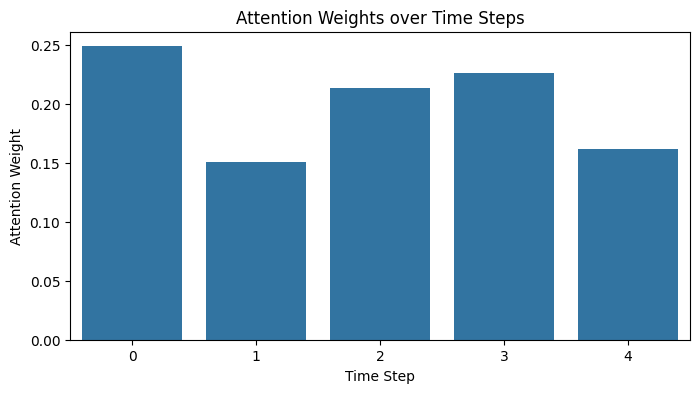

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Set seed for reproducibility
np.random.seed(42)

# --- 1. Create a fake time series (encoder outputs)
time_steps = 5
feature_dim = 3

# Imagine these are the encoder outputs (1 vector per time step)
encoder_outputs = np.random.rand(time_steps, feature_dim)

print("Encoder Outputs (time series):")
print(encoder_outputs)

# --- 2. Create a decoder hidden state (query)
# Let's pretend we are decoding at time t=0
decoder_hidden_state = np.random.rand(feature_dim)

print("\nDecoder Hidden State (Query):")
print(decoder_hidden_state)

# --- 3. Compute simple dot product attention
# Dot product between decoder hidden state and each encoder output
scores = np.dot(encoder_outputs, decoder_hidden_state)  # (5,)

print("\nDot product scores:")
print(scores)

# --- 4. Softmax over scores to get attention weights
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

attention_weights = softmax(scores)

print("\nAttention Weights (after softmax):")
print(attention_weights)
print("Sum of weights (should be 1.0):", np.sum(attention_weights))

# --- 5. Compute context vector (weighted sum)
context_vector = np.sum(attention_weights[:, None] * encoder_outputs, axis=0)

print("\nContext Vector (weighted sum of encoder outputs):")
print(context_vector)

# --- 6. Visualize the attention
plt.figure(figsize=(8, 4))
sns.barplot(x=np.arange(time_steps), y=attention_weights)
plt.title("Attention Weights over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.show()


Encoder Outputs (time series):
[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643]
 [0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184]
 [0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041]]

Decoder Hidden State (Query):
[0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735]

Keys Split into Heads:
(5, 2, 3)

Values Split into Heads:
(5, 2, 3)

Query Split into Heads:
(2, 3)

Head 0:
  Attention Weights: [0.20683154 0.16678631 0.23238624 0.18990182 0.20409409]
  Context Vector: [0.45571081 0.60600343 0.45085503]

Head 1:
  Attention Weights: [0.16420867 0.30863115 0.17214637 0.14358847 0.21142534]
  Context Vector: [0.47716249 0.25154688 0.47772109]

Final Context Vector (after concatenating heads):
[0.45571081 0.60600343 0.45085503 0.47716249 0.25154688 0.47772109]


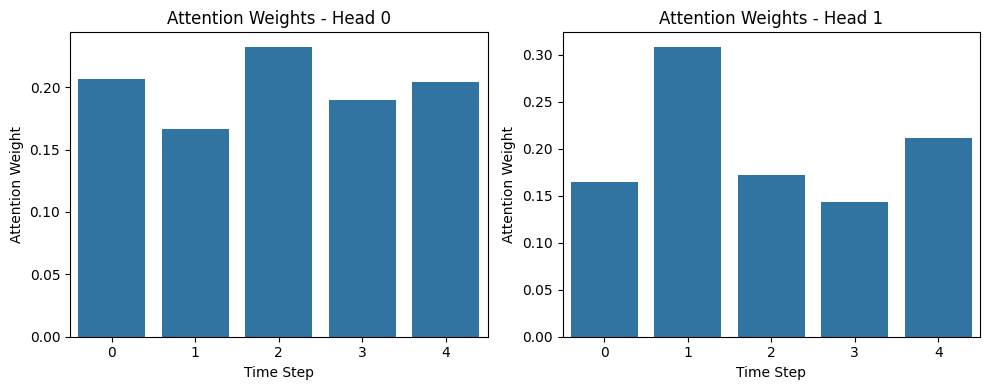

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Set seed for reproducibility
np.random.seed(42)

# --- 1. Create a fake time series (encoder outputs)
time_steps = 5
feature_dim = 6   # Must be divisible by num_heads
num_heads = 2
head_dim = feature_dim // num_heads

# Encoder outputs (sequence length = 5, feature_dim = 6)
encoder_outputs = np.random.rand(time_steps, feature_dim)

print("Encoder Outputs (time series):")
print(encoder_outputs)

# --- 2. Create a decoder hidden state
decoder_hidden_state = np.random.rand(feature_dim)

print("\nDecoder Hidden State (Query):")
print(decoder_hidden_state)

# --- 3. Split into multiple heads
def split_heads(x, num_heads):
    """Split last dimension into (num_heads, head_dim)"""
    batch_size = x.shape[0]
    return x.reshape(batch_size, num_heads, -1)

# Separate Query, Key, Value explicitly
keys = encoder_outputs  # (time_steps, feature_dim)
values = encoder_outputs  # (time_steps, feature_dim)
query = decoder_hidden_state  # (feature_dim,)

# Split across heads
keys_split = split_heads(keys, num_heads)        # (time_steps, num_heads, head_dim)
values_split = split_heads(values, num_heads)    # (time_steps, num_heads, head_dim)
query_split = split_heads(query[np.newaxis, :], num_heads)[0]  # (num_heads, head_dim)

print("\nKeys Split into Heads:")
print(keys_split.shape)   # (5, 2, 3)

print("\nValues Split into Heads:")
print(values_split.shape) # (5, 2, 3)

print("\nQuery Split into Heads:")
print(query_split.shape)  # (2, 3)

# --- 4. Compute attention per head
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

context_vectors = []
attention_weights_all_heads = []

for head_idx in range(num_heads):
    # Select for this head
    key_head = keys_split[:, head_idx, :]    # (time_steps, head_dim)
    value_head = values_split[:, head_idx, :]# (time_steps, head_dim)
    query_head = query_split[head_idx, :]    # (head_dim,)
    
    # Dot product (query ⋅ keys)
    scores = np.dot(key_head, query_head)  # (time_steps,)
    
    # Softmax
    attention_weights = softmax(scores)
    
    # Weighted sum over values
    context_vector = np.sum(attention_weights[:, None] * value_head, axis=0)
    
    # Save
    context_vectors.append(context_vector)
    attention_weights_all_heads.append(attention_weights)
    
    print(f"\nHead {head_idx}:")
    print("  Attention Weights:", attention_weights)
    print("  Context Vector:", context_vector)

# --- 5. Concatenate all heads
final_context = np.concatenate(context_vectors)

print("\nFinal Context Vector (after concatenating heads):")
print(final_context)

# --- 6. Visualize attention weights per head
plt.figure(figsize=(10, 4))

for head_idx, attention_weights in enumerate(attention_weights_all_heads):
    plt.subplot(1, num_heads, head_idx + 1)
    sns.barplot(x=np.arange(time_steps), y=attention_weights)
    plt.title(f"Attention Weights - Head {head_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Attention Weight")

plt.tight_layout()
plt.show()
